In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
import cv2
import math
import os
import imageio
from PIL import Image,ImageOps

from skimage import measure
from skimage.transform import resize, rescale
from skimage import img_as_ubyte

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam

In [2]:
from parameters import Div2kParameters
from gen import build_generator
from pretrained import pretrained_models
from predictions import get_sr_image
from config import config

In [3]:
dataset_key = "bicubic_x4"

data_path = config.get("data_path", "")

div2k_folder = os.path.abspath(os.path.join(data_path, "div2k"))

dataset_parameters = Div2kParameters(dataset_key, save_data_directory=div2k_folder)

In [4]:
def load_image(path):
    img = Image.open(path)

    was_grayscale = len(img.getbands()) == 1

    if was_grayscale or len(img.getbands()) == 4:
        img = img.convert('RGB')

    return was_grayscale, np.array(img)

In [23]:
model_name = "srgan"

In [24]:
model_key = f"{model_name}_{dataset_key}"

In [25]:
weights_directory = os.path.abspath(f"/content/drive/MyDrive/SRGAN/weights/{model_key}")

file_path = os.path.join(weights_directory, "generator.h5")

if not os.path.exists(file_path):
    os.makedirs(weights_directory, exist_ok=True)

    print("Couldn't find file: ", file_path, ", attempting to download a pretrained model")

    if model_key not in pretrained_models:
        print(f"Couldn't find pretrained model with key: {model_key}, available pretrained models: {pretrained_models.key()}")
    else:
        download_url = pretrained_models[model_key]
        file = file_path.split("/")[-1]
        tf.keras.utils.get_file(file, download_url, cache_subdir=weights_directory)

In [26]:
model = build_generator(scale=dataset_parameters.scale)

os.makedirs(weights_directory, exist_ok=True)
weights_file = f'{weights_directory}/generator.h5'

model.load_weights(weights_file)

In [ ]:
model.summary()

In [27]:
def psnr(img1, img2):
    mse = np.mean((np.array(img1) - np.array(img2)) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

In [28]:
def crop_image(image, crop_coords):
    """
    Crop an image based on the provided coordinates and return the cropped image.
    :param image: NumPy array or PIL Image object representing the input image.
    :param crop_coords: Tuple (left, upper, right, lower) specifying the crop coordinates.
    :return: Cropped image as a NumPy array or PIL Image object.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    cropped_image = image.crop(crop_coords)
    return cropped_image

In [29]:
output_folder = "/content/drive/MyDrive/SRGAN/Results/output/Set5"
input_folder = "/content/drive/MyDrive/test_dataset/Set5/LRbicx4/"
original_folder = "/content/drive/MyDrive/test_dataset/Set5/original"

# Iterate over files in the directory
for filename in os.listdir(input_folder):
    # Create the full file path
    image_path = os.path.join(input_folder, filename)

    print(image_path)

    # Load the image
    was_grayscale, lr = load_image(image_path)

    # Get the super-resolved image
    sr = get_sr_image(model, lr)

    if was_grayscale:
        sr = ImageOps.grayscale(sr)

    # Extract the image name from the full path
    image_name = os.path.basename(image_path)

    # Save the super-resolved image with the same name to the results directory
    sr.save(os.path.join(output_folder, image_name))


/content/drive/MyDrive/test_dataset/Set5/LRbicx4/bird.png
1/1 [==============================] - 1s 1s/step
/content/drive/MyDrive/test_dataset/Set5/LRbicx4/head.png
1/1 [==============================] - 1s 1s/step
/content/drive/MyDrive/test_dataset/Set5/LRbicx4/butterfly.png
1/1 [==============================] - 0s 338ms/step
/content/drive/MyDrive/test_dataset/Set5/LRbicx4/baby.png
1/1 [==============================] - 0s 374ms/step
/content/drive/MyDrive/test_dataset/Set5/LRbicx4/woman.png
1/1 [==============================] - 0s 281ms/step


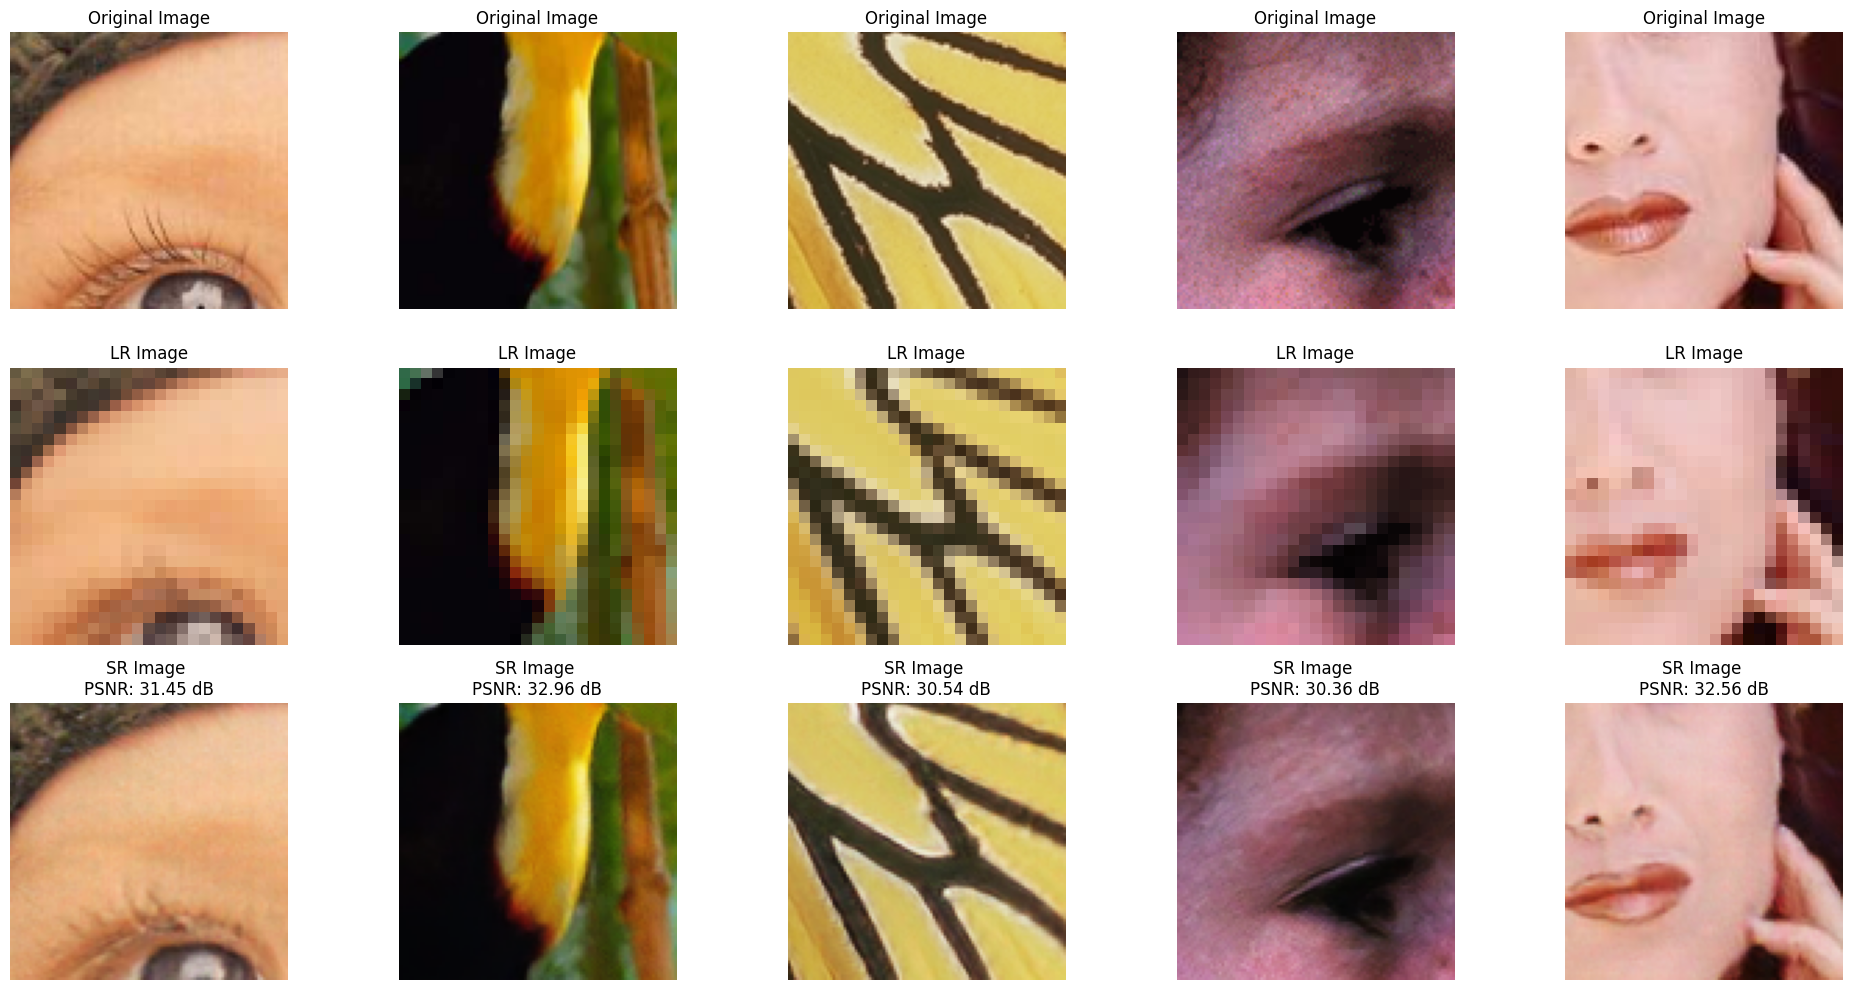

In [32]:
lr_crop_coords = (25, 25, 50, 50)
SR_HR_coords = (100,100,200,200)


# Get the list of image files in the folders
input_files = os.listdir(input_folder)
original_files = os.listdir(original_folder)
model_pred_files = os.listdir(output_folder)

# Sort the files to ensure consistent order
input_files.sort()
original_files.sort()
model_pred_files.sort()

# Select only the first 5 images
input_files = input_files[:]
original_files = original_files[:]
model_pred_files = model_pred_files[:]

# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(3, 5, figsize=(20, 10))

# Loop over the images and plot them
for i in range(5):
    # Read the LR and HR images
    lr_img = cv2.imread(os.path.join(input_folder, input_files[i]))
    og_img = cv2.imread(os.path.join(original_folder, original_files[i]))
    sr_img = cv2.imread(os.path.join(output_folder, model_pred_files[i]))

    # Convert BGR to RGB for plotting
    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
    og_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
    sr_img = cv2.cvtColor(sr_img, cv2.COLOR_BGR2RGB)

    #Crop Images
    lr_img = crop_image(lr_img, lr_crop_coords)
    og_img = crop_image(og_img, SR_HR_coords)
    sr_img = crop_image(sr_img,SR_HR_coords)

    calculate_psnr = psnr(np.array(og_img),np.array(sr_img))

    # Plot the LR image
    axes[0, i].imshow(og_img)
    axes[0, i].set_title("Original Image")
    axes[0, i].axis("off")

    # Plot the HR image
    axes[1, i].imshow(lr_img)
    axes[1, i].set_title("LR Image")
    axes[1, i].axis("off")

    # Plot the HR image
    axes[2, i].imshow(sr_img)
    axes[2, i].set_title(f"SR Image \nPSNR: {calculate_psnr:.2f} dB")
    axes[2, i].axis("off")

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/SRGAN/Results/output/Set5/SRGAN_set5_x4_plot.png')
